## Libraries

In [ ]:
!pip install sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'
!pip install sklearn_crfsuite
!pip install eli5
!pip install dframcy

In [1]:
# libraries
import pandas as pd
import numpy as np
import spacy
from dframcy import DframCy
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer
import scipy.stats
import eli5
import os
from os import listdir
from os.path import join, isfile
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score


## Data Loading

In [2]:
path = r'/home/user/Documents/GitHub/UL-labs/M2/2022-2023/Ontologies_and_Terminologies/Terminology/terminology-project-2022/curated/training_data' # use your path
all_files = glob.glob(path + "/*.final")

list = []
cols = ['Token', 'Tag']

for filename in all_files:
    df = pd.read_csv(filename, names = cols,on_bad_lines='skip', sep='\s+', engine='python')
    list.append(df)

train_df = pd.concat(list, axis=0, ignore_index=True)

In [3]:
path = r'/home/user/Documents/GitHub/UL-labs/M2/2022-2023/Ontologies_and_Terminologies/Terminology/terminology-project-2022/curated/test_data' # use your path
all_files = glob.glob(path + "/*.final")

list = []
cols = ['Token', 'Tag']

for filename in all_files:
    df = pd.read_csv(filename, names = cols,on_bad_lines='skip', sep='\s+', engine='python')
    list.append(df)

test_df = pd.concat(list, axis=0, ignore_index=True)

In [4]:
path = r'/home/user/Documents/GitHub/UL-labs/M2/2022-2023/Ontologies_and_Terminologies/Terminology/terminology-project-2022/curated/dev_data' # use your path
all_files = glob.glob(path + "/*.final")

list = []
cols = ['Token', 'Tag']

for filename in all_files:
    df = pd.read_csv(filename, names = cols,on_bad_lines='skip', sep='\s+', engine='python')
    list.append(df)

dev_df = pd.concat(list, axis=0, ignore_index=True)

## Preprocessing

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
# function for preprocessing of data
def preprocessing(df):
    #split tags from the token column 
    df.drop(df[df["Token"].isna()].index, inplace=True)
    for index in df[df["Tag"].isna()].index:
        token_tag = df["Token"][index].split()
        df["Token"][index] = token_tag[0]
        if len(token_tag) > 1:
            df["Tag"][index] = token_tag[1]

    # from a df['column'] to string
    list = df['Token'].values.tolist()
    text= ' '.join(map(str, list))

    # get the pos tagging
    text = nlp(text)
    df_pos = pd.DataFrame(columns=['Token', 'POS'])
    for token in text:
        df_pos = df_pos.append({'Token': token.text,
                        'POS': token.pos_,
                        }, ignore_index=True)

    # get the sentence index and the token index
    doc = nlp(text) 
    from dframcy import DframCy
    dframcy = DframCy(nlp)
    spacy_df = dframcy.to_dataframe(doc, ['is_sent_start','id', 'text']).reset_index()
    spacy_df.token_is_sent_start = spacy_df.token_is_sent_start.astype(bool).cumsum() - 1
    spacy_df = spacy_df.rename(columns={'token_is_sent_start': 'Sentence_id',
                                    'index': 'Index',
                                    'token_text': 'token_text'}) 

    #combine all dfs into one for the training data
    extracted_col = spacy_df["Sentence_id"]
    df_pos = df_pos.join(extracted_col)
    extracted_col = spacy_df["Index"]
    df_pos = df_pos.join(extracted_col)
    extracted_col = df["Tag"]
    df = df_pos.join(extracted_col)  

    #clean the token column from punctuation except for '-'
    df['Token'] = df['Token'].str.replace('[^\w-]|_', '', regex=True)
    df['Token'] = df['Token'].str.replace('nan', '', regex=True)
    df['Token'].replace('', np.nan, inplace=True)
    df.dropna(subset=['Token'], inplace=True)
  
    # clean the tag column 
    df['Tag'] = df['Tag'].replace(['II'], 'I')
    df['Tag'] = df['Tag'].replace(['0','o'], 'O')
    df['Tag'] = df['Tag'].replace(['b'], 'B')

    # drop nan values
    df['Token'].fillna('', inplace=True)
    df = df.dropna()
    
    
    return df

In [ ]:
# call the preprocessing function
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)
dev_df = preprocessing(dev_df)

## Random Forest Classifier

In [8]:
# get the whole dataset (use of cross validation) 
df_data = pd.concat([dev_df, test_df, train_df], ignore_index=True)

In [9]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(t1, p, t2) for t1, p, t2 in zip(s["Token"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

getter = getsentence(df_data)
sentences = getter.sentences


In [10]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(token):
    return np.array([token.istitle(), token.islower(), token.isupper(), len(token),
                     token.isdigit(),  token.isalpha()])

In [11]:
# divide the dataset into train and test sets
tokens = [feature_map(t1) for t1 in df_data["Token"].values.tolist()]
tags = df_data["Tag"].values.tolist()

In [12]:
#Random Forest classifier
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=tokens, y=tags, cv=5)

In [13]:
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

           B       0.58      0.09      0.16      3006
           I       0.59      0.12      0.20      3242
           O       0.75      0.98      0.85     16004

    accuracy                           0.74     22252
   macro avg       0.64      0.40      0.40     22252
weighted avg       0.70      0.74      0.66     22252



/home/user/Documents/GitHub/UL-labs/M2/2022-2023/Ontologies_and_Terminologies/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['B', 'I', 'O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[Text(0.5, 19.049999999999997, 'predicted'), Text(46.25, 0.5, 'actual')]

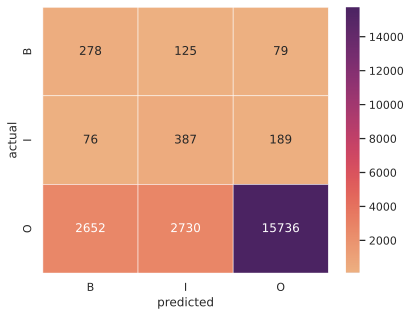

In [26]:
# confusion matrix
labels=['B', 'I', 'O']
conf_mat = confusion_matrix(pred, tags, labels)
sns.set(font_scale=1)
x_axis_labels = labels
y_axis_labels = labels
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare', xticklabels=x_axis_labels,
                     yticklabels=y_axis_labels)
matrix.set(xlabel='predicted', ylabel='actual')

## Conditional random fields

In [23]:
# extract the features
def extract_sentence_features(df):
    sentence_length = len(df)

    for i in range(sentence_length):
        token = df.iloc[i]['Token']        
        postag = df.iloc[i]['POS']
        features = {
            'bias': 1.0,
            'token.lower()': token.lower(),
            'token.isupper()': token.isupper(),
            'token.istitle()': token.istitle(),
            'token.isdigit()': token.isdigit(),
            'postag': postag
            #'postag[:2]': postag[:2],
        }

        if i > 0:
            previous_token = df.iloc[i-1]['Token']
            previous_tok_postag = df.iloc[i-1]['POS']
            features.update({
                'previous_token.lower()': previous_token.lower(),
                'previous_token.isupper()': previous_token.isupper(),
                'previous_token.istitle()': previous_token.istitle(),
                'previous_token.isdigit()': previous_token.isdigit(),
                'previous_token.postag': previous_tok_postag
            })
        else:
            features['BOS'] = True

        if i < sentence_length - 1:
            posterior_token = df.iloc[i+1]['Token']
            posterior_tok_postag = df.iloc[i+1]['POS']
            features.update({
                'posterior_token.lower()': posterior_token.lower(),
                'posterior_token.isupper()': posterior_token.isupper(),
                'posterior_token.istitle()': posterior_token.istitle(),
                'posterior_token.isdigit()': posterior_token.isdigit(),
                'posterior_token.postag': posterior_tok_postag
            })
        else:
            features['EOS'] = True

        yield features

In [24]:
def prepare(df, include_y=False):
    X, y = [], []
    for _, group_df in df.groupby(['Index', 'Sentence_id']):
        X.append(extract_sentence_features(group_df))
        if include_y:
            y.append(group_df['Tag'])
    if include_y:
        return X, y
    return X

In [25]:
# combine train and dev dataset
df_data = pd.concat([dev_df, train_df], ignore_index=True)

In [26]:
X_train, y_train = prepare(df_data, include_y=True)
X_test, y_test = prepare(test_df, include_y=True)  

In [27]:
#Creating the CRF model
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [28]:
# fit the model
crf.fit(X_train, y_train)


/home/user/Documents/GitHub/UL-labs/M2/2022-2023/Ontologies_and_Terminologies/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [29]:
y_pred = crf.predict(X_test)


## Evaluation

In [30]:
print(metrics.flat_classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           B       0.62      0.59      0.61       328
           I       0.64      0.46      0.54       386
           O       0.87      0.93      0.90      1802

    accuracy                           0.82      2516
   macro avg       0.71      0.66      0.68      2516
weighted avg       0.80      0.82      0.81      2516



/home/user/Documents/GitHub/UL-labs/M2/2022-2023/Ontologies_and_Terminologies/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


/home/user/Documents/GitHub/UL-labs/M2/2022-2023/Ontologies_and_Terminologies/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['O', 'I', 'B'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[Text(0.5, 19.049999999999997, 'predicted'), Text(46.25, 0.5, 'actual')]

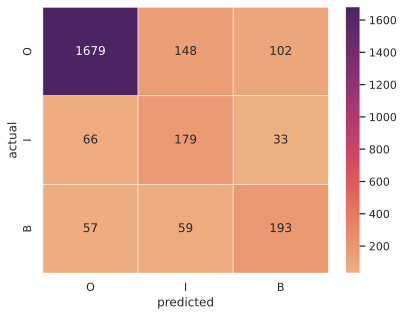

In [31]:
# confusion matrix
labels=['O', 'I', 'B']
conf_mat = confusion_matrix(y_pred, y_test, labels)
sns.set(font_scale=1)
x_axis_labels = labels
y_axis_labels = labels
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare', xticklabels=x_axis_labels,
                     yticklabels=y_axis_labels)
matrix.set(xlabel='predicted', ylabel='actual')